# CS110 Final Project

## Description
I want to create an application to find if a word or sentence is present in a text. Some of the uses for this application are (1) quickly searching for a word or sentence in a long text, (2) finding out what song contains a word or sentence you are looking for, (3) predicting the next word in a sentence (this one depends on the implementation). I will use and compare two strategies: a trie tree and a hash table. 

## Hash table approach
There are several different kinds of hash tables. In this assignment, I will use both an implementation using chaining. My strategy will be to generate all possible sequences of words and store them in a hash table. There are other methods of building the same application, such as the Rabin-Karp algorithm, where none of the keys needs to be actually stored, we simply compute and compare the hash value of the word we are looking for with all substrings of the text of the same length. Here, however, I want a method that can find words in O(1) time, even if the construction of the hash table might take longer and occupy more space.

In [1]:
import random
import string

def preprocess4(text):
    """
    Returns all possible combination of contiguous words
    
    Parameters
    -----------
    text: str
    
    Output
    -----------
    all_subwords: lst
        A list containing all possible sequences of contiguous words
    """
    text = text.lower()
    bad_chars = [
        ';', ',', '.', '?', '!', '_',
        '[', ']', ':', '“', '”', '"', '–', '-', "(", ")"
    ]
    just_text = ''.join(c for c in text if c not in bad_chars)
    without_newlines = ''.join(c if (c not in ['\n', '\r', '\t']) else " "
                               for c in just_text)
    just_text = ''.join(c for c in without_newlines if c not in bad_chars)
    just_words = [word for word in just_text.split(" ") if word != ""]
    all_subwords = []
    N = len(just_words)
    for idx in range(N):
        for end_idx in range(idx, N):
            fragment = " ".join(just_words[idx:end_idx+1])
            all_subwords.append(fragment)
            
    return all_subwords

def randomword(length):
    """
    Returns a random word of the length specified
    """
    return ''.join(random.choice(string.ascii_lowercase) for i in range(length))


def empty_hash_table(N):
    return [[] for n in range(N)]


def add_to_hash_table(hash_table, item, hash_function):
    """
    Adds a string to the specified hash table using a specified hash function.
    """
    N = len(hash_table)
    hash_ = hash_function(item)
    resized_hash = hash_%N
    hash_table[resized_hash].append(item)
    return hash_table


def contains(hash_table, item, hash_function):
    N = len(hash_table)
    hash_ = hash_function(item)
    resized_hash = hash_%N
    for i in hash_table[resized_hash]:
        if i == item:
            return True
    return False
    # return true if the item has already been stored in the hash_table


def remove(hash_table, item, hash_function):
    if not contains(hash_table, item, hash_function):
        raise ValueError()
    N = len(hash_table)
    hash_ = hash_function(item)
    resized_hash = hash_%N
    for i in hash_table[resized_hash]:
        if i == item:
            del i
    return hash_table


# Hash Functions
def hash_str1(string):
    ans = 0
    for chr in string:
        ans += ord(chr)
    return ans

def hash_str2(string):
    ans=int(ord(string[0]))
    for ix in range(1, len(string)):
        ans = ans ^ ord(string[ix]) 
    return int(bin(ans).split('b')[1])

def hash_str3(string):
    ans = 0
    for chr in string:
        ans = ans * 33 + ord(chr) # changed from 128 to 33 because 33 is prime.
    return ans

def hash_str4(string):
    random.seed(ord(string[0]))
    return random.getrandbits(32)

### Hash Table considerations
An important consideration in the size of the hash table. Ideally, the size should be big enough to avoid collisions. The time it takes to lookup an key depends on the load factor $\alpha$. In an implementation with chaining, the average-case time is $\Theta (1 + \alpha)$, so it is important to keep the load factor smaller than 1 in order to maintain $O(1)$ lookup time. Furthermore, the size of the table should be a prime number, because when we take the modulus of the hash value to find the corresponding index in the table, we want to prevent that any uneven distribution in the keys might cause some spots to be filled more than others. Even numbers, especially a power of 2, are bad because often the distribution of keys follow a power of 2 pattern due to the binary system used by most computers. This would generate the same indexes for many different inputs, creating collisions. So, as a rule of thumb, I will use for the table size the first prime number such that my keys occupy at most 75% of the table capacity.

Note: Finding a big prime is computationally expensive, so, unless specified by the user, I will use the first odd (not necessarily prime) number that guarantees the 75% rule.

### Hash Function considerations
I want a hash function that distributes the keys evenly between the slots of the table, in order to avoid collisions as much as possible, as they hinder our O(1) time complexity. To chose a good hash function, I will plot their hash distribution for a random set of words and for a set of sentence fragments taken from a speech, to make sure the hash function deals well with strings of varying size and with letters occurring in different frequencies. 

In [2]:
import matplotlib.pyplot as plt
def plot_distribution(hash_function, words, len_table):
    """
    Plots the distribution of hash values for a specified hash function
    
    Parameters
    -----------
    hash_function: function
    
    words: lst
        A lst containing strings 
    
    len_table: int
        The size of the simulated hash table
    
    """
    plt.figure()
    lst = [hash_function(word)%len_table for word in words]
    plt.hist(lst, bins = len_table)
    plt.ylabel("Collisions")
    plt.xlabel("Slot")


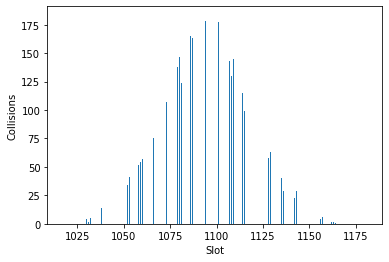

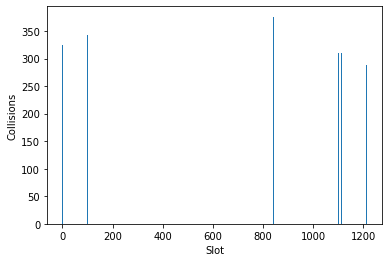

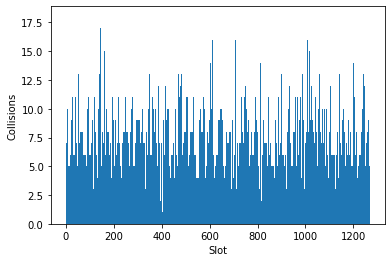

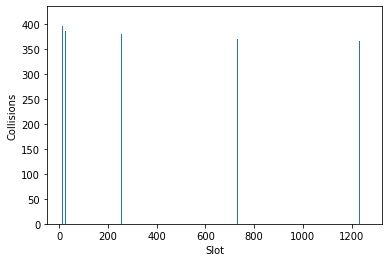

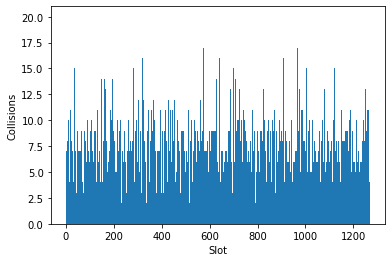

In [3]:
random_words = [randomword(10) for i in range(10000)]
plot_distribution(hash_str1, random_words, 1271)    
plot_distribution(hash_str2, random_words, 1271)  
plot_distribution(hash_str3, random_words, 1271)  
plot_distribution(hash_str4, random_words, 1271)  
plot_distribution(hash, random_words, 1271) # built-in Python hash function

Clearly hash_str3 and the built-in function hash perform the best with random words. Let's test them with natural language text.

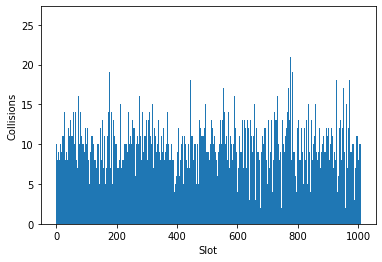

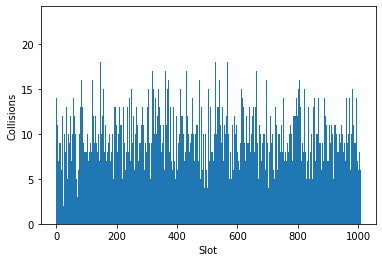

In [4]:
from requests import get
thunberg = get('https://bit.ly/CS110-Thunberg').text # Greta Thunberg - UN
all_subwords = preprocess4(thunberg)
random.shuffle(all_subwords)
plot_distribution(hash_str3, all_subwords[:10000], 1009)  
plot_distribution(hash, all_subwords[:10000], 1009) # built-in Python hash function

They have nearly the same performance, which assures me I can use hash_str3 with confidence it will produce next to the minimum amount of collisions. The distribution is far from being even, but no hash function can produce perfect results.

### Strategy
I will store all combinations of contiguous words into a hash table. Then, to find if a word or sentence is present in the text, I simply need to look up the word or sentence using its hash value. If the lookup is successful, the word or sentence is present. If not, it isn't.

In [5]:
from tqdm import tqdm

def preprocess(text):
    """
    Returns the text without spaces and special characters
    """
    text = text.lower()
    bad_chars = [
    ';', ',', '.', '?', '!', '_',
    '[', ']', ':', '“', '”', '"', '–', '-', "(", ")"
    ]
    just_text = ''.join(c for c in text if c not in bad_chars)
    without_newlines = ''.join(c if (c not in ['\n', '\r', '\t']) else " "
                               for c in just_text)
    just_text = ''.join(c for c in without_newlines if (c not in bad_chars))
    return just_text

def store(hash_table, items, hash_function):
    """
    Stores all items of a list in a hash table
    """
    for item in items:
        add_to_hash_table(hash_table, item, hash_function)


def calculate_table_size(preprocessed_text):
    """
    Returns the first odd number that ensures keys 
    will occupy at most 75% of the hash table capacity
    """
    # making keys fit in 75% of the table
    size = round((len(preprocessed_text)/0.75))
    
    #making sure table size is an odd number
    if size % 2 == 0:
        size += 1
        
    return size
    
def hash_preprocess(text, table_size = None):
    """
    Does the necessary preprocessing for the algorithm
    """
    
    # finding all subwords
    all_subwords = preprocess4(text)
    
    if not table_size:
        table_size = calculate_table_size(all_subwords)
    
    # making empty hash table
    table = empty_hash_table(table_size)
    
    # storing all subwords
    store(table, all_subwords, hash_str3)
    
    return table



def hash_sentence_finder(preprocessed_text, sentence):
    """
    Looks for a word or sentence in a text. Returns true if it is in the text, False, if it isn't.
    """
    # removing special characters
    sentence = preprocess(sentence)

    return contains(preprocessed_text, sentence, hash_str3)



In [6]:
text = "This is a text"
new_text = hash_preprocess(text, table_size = 19)

assert hash_sentence_finder(new_text, "text") == True # finds words
assert hash_sentence_finder(new_text, "tex") == False # but not incomplete words
assert hash_sentence_finder(new_text, "is a text") == True # finds sentences
assert hash_sentence_finder(new_text, "Th?!is iS?") == True # ignores special characters
assert hash_sentence_finder(new_text, "is text") == False  # words are in text, but not in the correct order
assert hash_sentence_finder(new_text, "") == False # edge case, empty string


In [7]:
preprocessed_thunberg = hash_preprocess(thunberg) # it takes a while
assert hash_sentence_finder(preprocessed_thunberg,"i should be") == True 
assert hash_sentence_finder(preprocessed_thunberg,"shoul") == False
assert hash_sentence_finder(preprocessed_thunberg,
                            "You have stolen my dreams and my childhood with your empty words. And yet I'm one of the lucky ones. People are suffering. People are dying. Entire ecosystems are collapsing. We are in the beginning of a mass extinction, and all you can talk about is money and fairy tales of eternal economic growth. How dare you!"
                           ) == True  # Long sentence!

In my tests, I include the normal usage of the function as well as edge cases, such as empty strings, to test if the algorithm is robust. I demonstrate that it is capable of finding individual words and sentences, dealing with special characters and capitalization, and that it does not find incomplete words. I then use the algorithm in a long text, which is the expected use case, demonstrating it still works.

## Trie Tree Approach

I will modify the trie tree used in the last assignment so that it can store sentences. Just like the hash table approach, I will store all possible combinations of contiguous words. To do so, we first preprocess the text to generate substrings that start at different words. For example, if the text is "My lovely cat", the preprocessed text will be a list containing ["my lovely cat", "lovely cat", "cat"]. We do this to ensure that the search can be done starting at any word in the text. 
The tree then stores each character of the sentence in a different node, where the child of each node is the next character in the sentence. We mark the characters that represent the end of each word so that we distinguish prefixes from full words from full sentences.

In [8]:
class Node:
    """This class represents one node of a trie tree.
    
    Parameters
    ----------
    
    char: str
        the character stored in the node
    children: list
        the children nodes
    end_of_word : boolean
        signals if the node is at the end of a word
    """
    def __init__(self, char=None, parent=None):
        self.char = char  # character stored in the node
        self.children = []  # list containing the children nodes
        self.end_of_word = False  # signal if node is the end of a valid word
        self.beg_of_word = False # # signal if node is the beginning of a valid word
        self.reps = 0 # how many times the word occurs


class Trie:
    """This class represents the entirety of a trie tree.
    
    Parameters
    ----------
    The parameters for Trie's __init__ are not predetermined.
    However, you will likely need one or more of them.    
    
    Methods
    -------
    insert(self, word)
        Inserts a word into the trie, creating nodes as required.
    lookup(self, word)
        Determines whether a given word is present in the trie.
    """
    def __init__(self, words_list=None):
        """Creates the Trie instance, inserts initial words if provided.
        
        Parameters
        ----------
        word_list : list
            List of strings to be inserted into the trie upon creation.
        """
        self.root = Node()  # creates an empty root
        
        if words_list:
            for words in words_list:
                self.insert(words)
    
        
    def insert(self, words: str):
        """Inserts a word into the trie, creating missing nodes on the go.
        
        Parameters
        ----------
        word : str
            The word to be inserted into the trie.
        """
        cur_node = self.root
        for word in words:
            word = word.lower()  # convert word to lowercase
            for letter in word:
                # check is the character is already in the children of current node
                is_in_children = False
                for child in cur_node.children:

                    # if it is, assign the current character to the child containing the character
                    if child.char == letter:
                        cur_node = child
                        is_in_children = True
                        break

                # if not, create a new child with that character
                if is_in_children == False:
                    new_node = Node(char=letter, parent=cur_node)
                    cur_node.children.append(new_node)
                    cur_node.children = sorted(cur_node.children,
                                               key=lambda x: x.char)
                    cur_node = new_node
        
            cur_node.reps += 1 # adds oe to te number of occurences of the word
            cur_node.end_of_word = True  # signal that this is the last node of a complete word

    def lookup(self, word: str):
        """Determines whether a given word is present in the trie.
        
        Parameters
        ----------
        word : str
            The word to be looked-up in the trie.
            
        Returns
        -------
        bool
            True if the word is present in trie; False otherwise.
            
        Notes
        -----
        Your trie should ignore whether a word is capitalized.
        E.g. trie.insert('Prague') should lead to trie.lookup('prague') = True
        """
        word = preprocess(word)
        word = word.lower()
        cur_node = self.root 
        for letter in word: 
            
            # check if the character is already in the children of current node
            is_in_children = False
            for child in cur_node.children:
                # if it is, assign the current node to the child containing the character
                if child.char == letter:
                    cur_node = child
                    is_in_children = True
            # if not, return false
            if is_in_children == False:
                return False
        
        # returns False if the word is just a prefix, returns True if it's a valid word
        return cur_node.end_of_word 

In [9]:
def preprocess3(text, size = 10):
    bad_chars = [
        ';', ',', '.', '?', '!', '_',
        '[', ']', ':', '“', '”', '"', '–', '-', "(", ")"
    ]
    just_text = ''.join(c for c in text if c not in bad_chars)
    without_newlines = ''.join(c if (c not in ['\n', '\r', '\t']) else " "
                               for c in just_text)
    just_text = ''.join(c for c in without_newlines if c not in bad_chars)
    just_words = [word for word in just_text.split(" ") if word != ""]
    all_subwords = []
    N = len(just_words)
    for idx in range(N):
        fragment = [" " + i for i in just_words[idx:min(idx + size, N+1)]]
        fragment[0] = fragment[0][1:]
        all_subwords.append(fragment)
            
    return all_subwords

def trie_preprocess(text):
    all_subwords = preprocess3(text, len(text))
    trie = Trie(all_subwords)
    return trie

def trie_sentence_finder(preprocessed_text, sentence):
    sentence = preprocess(sentence)
    return preprocessed_text.lookup(sentence)

In [10]:
preprocessed_text = trie_preprocess("This is a text")


assert trie_sentence_finder(preprocessed_text,"text") == True # finds words
assert trie_sentence_finder(preprocessed_text,"tex") == False # but not incomplete words
assert trie_sentence_finder(preprocessed_text,"is a text") == True # finds sentences
assert trie_sentence_finder(preprocessed_text,"Th?!is iS?") == True # ignores special characters
assert trie_sentence_finder(preprocessed_text,"is text") == False  # words are in text, but not in the correct order
assert trie_sentence_finder(preprocessed_text,"") == False # edge case, empty string

In [11]:
preprocessed_thunberg = trie_preprocess(thunberg)
assert trie_sentence_finder(preprocessed_thunberg,"i should be") == True 
assert trie_sentence_finder(preprocessed_thunberg,"shoul") == False
assert trie_sentence_finder(preprocessed_thunberg,
                            "You have stolen my dreams and my childhood with your empty words. And yet I'm one of the lucky ones. People are suffering. People are dying. Entire ecosystems are collapsing. We are in the beginning of a mass extinction, and all you can talk about is money and fairy tales of eternal economic growth. How dare you!"
                           ) == True  # Long sentence!


I use the same test cases as before to demonstrate both algorithms behave the same way.

## Comparing the approaches

### Time complexity

#### Hash table

With our current implementation, there are 2 main steps that the algorithm takes. First, it preprocesses and inserts the text into the hash table. This step can be divided in two parts, as following:
1. First, we need to preprocess the text. There are $\frac{N(N+1)}{2}$ combinations of contiguous words, where $N$ is the number of words in the text, and the algorithm takes a fixed amount of time to slice each sentence and add them to a list. The time complexity of creating an empty hash table is proportional on the number of items so we can express both with a time complexity of $O(n^2)$.
2. We need to calculate the hash of each of these sentences and include them in the hash table. For each of the $\frac{N(N+1)}{2}$ items, we need to iterate through each character. So, the time complexity of the calculating the hash is $O(n^2 \cdot m)$, where m is the average length of each sentence, which in turn is around half of the text length (it is actually a bit smaller because of spaces). If $m = N/2$, the time complexity becomes $O(n^2 \cdot n/2) = O(n^3)$. Inserting the item in the table takes a constant time, as we already have the its position calculated. 

Overall, the time complexity of the 'preparation' part is $O(n^2 + n^3) = O(n^3)$.

The next step for the algorithm is to lookup a sentence. For that, we need to calculate the hash value of the sentence, which takes $O(s)$, where s is the length of the sentence. The lookup part depends on the load factor, but since we are using a load factor smaller than 1, the average time of the lookup will be $O(1)$. The worst time complexity is $O(n^2)$, but it is extremely unlikely to happen. Overall, the average time complexity for the lookup part of the algorithm is $O(s + 1) = O(s)$. 

Note: In this implementation, the lookup algorithm also preprocesses the sentence before actually looking for it. The preprocessing part also has $O(s)$ scaling behavior.

#### Trie Trees

Just like the hash table, there are 2 main steps that the trie tree algorithm takes. First, it preprocesses and inserts the text into the trie tree. There are $\frac{N(N+1)}{2}$ combinations of contiguous words, where $N$ is the number of words in the text. However, unlike the hash table, we don't need to insert all possible combinations, since we mark the ending of each word. We actually only make N insertions, each of a sentence starting at a different word of the text. Inserting each sentence takes $O(m)$ time, where m is the length of the sentence. 

As discussed before, $m = N/2$, so the overall preprocessing takes $O(N \cdot m) = O(N \cdot N/2) = O(N^2).$ 


The next step for the algorithm is to lookup a sentence. Paraphrasing my previous assignment: we can check the existence of each character of the sentence O(1) time, because moving to the next node (if the character is already in the children) takes a fixed number of steps; they don't depend on the characteristics of the tree. Searching for a character in the current children of a node depends on the number of possible characters in our word bank. Still, if we assume a fixed number of characters (the English alphabet, for example), this operation will make at most the number of iterations as there are letters in our alphabet, which we can write as O(1). 

So, we have for lookup(): O(1) * s = $O(s)$, where s is the length of the sentence.

Note: In this implementation, the lookup algorithm also preprocesses the sentence before actually looking for it. The preprocessing part also hash $O(s)$ scaling behavior.

### Empirical analysis

#### Hash table
##### Preprocessing

In [12]:
import time
def random_sentence(n_words, word_length):
    """
    Generates multiple random words and puts them into a text, 
    separated by spaces
    """
    sentence = ""
    for i in range(n_words):
        sentence += randomword(word_length) + " "
    return sentence

def preprocess_timer(max_words, runs, function):
    """
    Times the preprocessing part of the sentence finder algorithm.
    """
    all_seconds = []

    for i in tqdm(range(1, max_words, 20)):
        text = random_sentence(i, 10)
        seconds = 0
        for j in range(runs):
            start = time.time()
            subwords = function(text)
            end = time.time()
            seconds += (end - start)
        all_seconds.append(seconds/runs)
    return all_seconds

In [13]:
max_words = 160
runs = 50
all_seconds_hash = preprocess_timer(max_words, runs, hash_preprocess)
all_seconds_trie = preprocess_timer(max_words, runs, trie_preprocess)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:10<00:00,  8.85s/it]


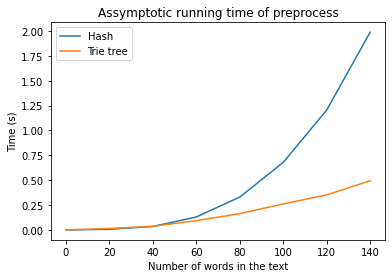

In [14]:
plt.plot([i*20 for i in range(len(all_seconds_hash))], all_seconds_hash, label = "Hash")
plt.plot([i*20 for i in range(len(all_seconds_trie))], all_seconds_trie, label = "Trie tree")
plt.title("Assymptotic running time of preprocess")
plt.ylabel("Time (s)")
plt.xlabel("Number of words in the text")
plt.legend()

##### Lookup

In [15]:
def lookup_timer(max_length, runs, pre_function, function, input_ = None, word_length = 50):
    """
    Times the lookup part of the sentence finder algorithm.
    """
    # text with words of varying lengths
    text = random_sentence(max_length, word_length)
    
    subwords = pre_function(text)
    
    # Ability to define custom text input
    if input_:
        text = input_
    
    text_lst = text.split()
    
    all_seconds_lookup = []
    for i in tqdm(range(1, len(text_lst), 5)):
        seconds = 0
        for j in range(runs):
            start = time.time()
            #print(" ".join(text_lst[:i]))
            function(subwords, " ".join(text_lst[:i]))
            end = time.time()
            seconds += (end - start)
        all_seconds_lookup.append(seconds/runs)
    return all_seconds_lookup


In [16]:
max_length = 100
runs = 100
all_seconds_f_hash = lookup_timer(max_length, runs, hash_preprocess, hash_sentence_finder)
all_seconds_f_trie = lookup_timer(max_length, runs, trie_preprocess, trie_sentence_finder)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.94it/s]


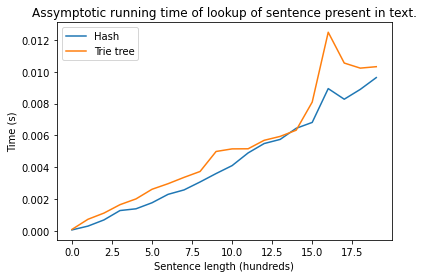

In [17]:
plt.plot([i for i in range(len(all_seconds_f_hash))], all_seconds_f_hash, label = "Hash")
plt.plot([i for i in range(len(all_seconds_f_trie))], all_seconds_f_trie, label = "Trie tree")
plt.title("Assymptotic running time of lookup of sentence present in text.")
plt.ylabel("Time (s)")
plt.xlabel("Sentence length (hundreds)")
plt.legend()

In [18]:
max_length = 100
word_length = 50
runs = 100
text = random_sentence(max_length, word_length)
#all_seconds_f_hash = lookup_timer(max_length, runs, hash_preprocess, hash_sentence_finder, input_ = text)
all_seconds_f_trie = lookup_timer(max_length, runs, trie_preprocess, trie_sentence_finder, input_ = text)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.48it/s]


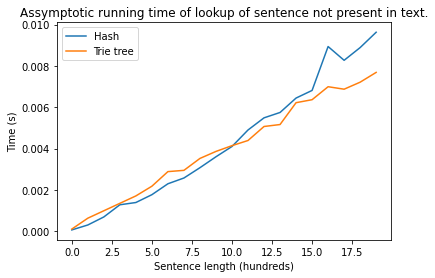

In [19]:
plt.plot([i for i in range(len(all_seconds_f_hash))], all_seconds_f_hash, label = "Hash")
plt.plot([i for i in range(len(all_seconds_f_trie))], all_seconds_f_trie, label = "Trie tree")
plt.title("Assymptotic running time of lookup of sentence not present in text.")
plt.ylabel("Time (s)")
plt.xlabel("Sentence length (hundreds)")
plt.legend()

In agreement with our analytical investigation of the assymptotic runtime, both function increase linearly with the length of the sentence being looked up.

## Conclusion

It seems like the trie trees can be a good substitution for a naive implementation of hash tables. I say naive because there are much smarter algorithms out there that can preprocess and lookup long texts much faster, such as rolling hashing. In our implementation, trie trees performed asymptotically better in the preprocessing part and just as good in the lookup time, compared to hash tables. The space complexity is also better, since we only need to store N sentences, while the hash table requires N*(N+1)/2. 

Additionally, the trie trees have other interesting capabilities, such as quickly printing the words in alphabetical order, and storing which words are used most in the text, which can be useful to build something like an autocomplete or even a sentence predictor. In the next cell, I try to demonstrate a few of these capabilities.

In [20]:
import random

def preprocess2(text):
    """
    Returns a list of just the words in the text, without special characters.
    """
    bad_chars = [
        ';', ',', '.', '?', '!', '_',
        '[', ']', ':', '“', '”', '"', '–', '-', "(", ")"
    ]
    just_text = ''.join(c for c in text if c not in bad_chars)
    without_newlines = ''.join(c if (c not in ['\n', '\r', '\t']) else " "
                               for c in just_text)
    just_text = ''.join(c for c in without_newlines if c not in bad_chars)
    just_words = [word for word in just_text.split(" ") if word != ""]
    
    return just_words



class Node:
    """This class represents one node of a trie tree.
    
    Parameters
    ----------
    
    char: str
        the character stored in the node
    children: list
        the children nodes
    end_of_word : boolean
        signals if the node is at the end of a word
    """
    def __init__(self, char=None, parent=None):
        self.char = char  # character stored in the node
        self.children = []  # list containing the children nodes
        self.end_of_word = False  # signal if node is the end of a valid word
        self.beg_of_word = False # # signal if node is the beginning of a valid word
        self.reps = 0 # how many times the word occurs


class Trie:
    """This class represents the entirety of a trie tree.
    
    Parameters
    ----------
    The parameters for Trie's __init__ are not predetermined.
    However, you will likely need one or more of them.    
    
    Methods
    -------
    insert(self, word)
        Inserts a word into the trie, creating nodes as required.
    lookup(self, word)
        Determines whether a given word is present in the trie.
    """
    def __init__(self, words_list=None):
        """Creates the Trie instance, inserts initial words if provided.
        
        Parameters
        ----------
        word_list : list
            List of strings to be inserted into the trie upon creation.
        """
        self.root = Node()  # creates an empty root
        
        if words_list:
            for words in words_list:
                self.insert(words)
    
        
    def insert(self, words: str):
        """Inserts a word into the trie, creating missing nodes on the go.
        
        Parameters
        ----------
        word : str
            The word to be inserted into the trie.
        """
        cur_node = self.root
        for word in words:
            word = word.lower()  # convert word to lowercase
            for letter in word:
                # check is the character is already in the children of current node
                is_in_children = False
                for child in cur_node.children:

                    # if it is, assign the current character to the child containing the character
                    if child.char == letter:
                        cur_node = child
                        is_in_children = True
                        break

                # if not, create a new child with that character
                if is_in_children == False:
                    new_node = Node(char=letter, parent=cur_node)
                    cur_node.children.append(new_node)
                    cur_node.children = sorted(cur_node.children,
                                               key=lambda x: x.char)
                    cur_node = new_node
        
            cur_node.reps += 1 # adds oe to te number of occurences of the word
            cur_node.end_of_word = True  # signal that this is the last node of a complete word

    def lookup(self, word: str):
        """Determines whether a given word is present in the trie.
        
        Parameters
        ----------
        word : str
            The word to be looked-up in the trie.
            
        Returns
        -------
        bool
            True if the word is present in trie; False otherwise.
            
        Notes
        -----
        Your trie should ignore whether a word is capitalized.
        E.g. trie.insert('Prague') should lead to trie.lookup('prague') = True
        """
        word = preprocess(word)
        word = word.lower()
        cur_node = self.root 
        for letter in word: 
            
            # check if the character is already in the children of current node
            is_in_children = False
            for child in cur_node.children:
                # if it is, assign the current node to the child containing the character
                if child.char == letter:
                    cur_node = child
                    is_in_children = True
            # if not, return false
            if is_in_children == False:
                return False
        
        # returns False if the word is just a prefix, returns True if it's a valid word
        return cur_node.end_of_word 

    
        
    def make_heap(self, cur_node=None, word=None, heap_words=None, new_word = False):
        '''
        Auxiliary function for k_most_common() and autocomplete(). 
        
        Works the same as alphabet_list, but creates a heap of words instead of a list.
        '''
        import heapq
        
        # initializing arguments
        if heap_words == None:
            heap_words = [] # a heap
        if word == None:
            word = ''
        if cur_node == None:
            cur_node = self.root

        if cur_node.children != []:  # base case, this is a leaf node

            # for each children
            if new_word == True:
                available_children = [child for child in cur_node.children if child.char == " "]
                new_word = False
            else:
                available_children = cur_node.children
                
            for node in available_children:
                # if the node is the end of a word, add the word to the list
                    
                if node.end_of_word == True:
                    
                    
                    complete_word = word + node.char
                    
                    heapq.heappush(heap_words, (-node.reps, complete_word))
                    return heap_words# return to avoid adding longer sentences unnecessarily 
                
                # call the function recursively on the current node
                
                # this is to avoid including spaces twice.
                if node.char != " ":
                    self.make_heap(cur_node=node,
                                       word=word + node.char,
                                       heap_words=heap_words, new_word = new_word)
                else:
                    self.make_heap(cur_node=node,
                                       word=word,
                                       heap_words=heap_words, new_word = new_word)
                
        heapq.heappush(heap_words, (0, ""))
        return heap_words
        

    def autocomplete(self, prefix):
        """Finds the most common word with the given prefix.

        You might want to reuse some functionality or ideas from Q4.

        Parameters
        ----------
        prefix : str
            The word part to be “autocompleted”.

        Returns
        ----------
        str
            The complete, most common word with the given prefix.

        Notes
        ----------
        The return value is equal to prefix if there is no valid word in the trie.
        The return value is also equal to prefix if prefix is the most common word.
        """
        import heapq

        word = prefix.lower()
        cur_node = self.root
        for letter in word:

            # check is the character is already in the children of current node
            is_in_children = False
            for child in cur_node.children:

                # if it is, assign the current character to the child containing the character
                if child.char == letter:
                    cur_node = child
                    is_in_children = True
                    break

            # if not, return the prefix
            if is_in_children == False:
                return prefix


        # makes heap of words with auxiliary function
        heap_words = self.make_heap(cur_node = cur_node, word = prefix)
        heapq.heappush(heap_words,(-cur_node.reps, prefix) )
        return heapq.heappop(heap_words)[1]
    
    def autocomplete_sentence(self, prefix, full = True):
        """
        Finds the most common next word given a sentence fragment

        Parameters
        ----------
        prefix : str
            The word part to be “autocompleted”.

        Returns
        ----------
        str
            The complete, most common word with the given prefix.
            
        Notes
        ----------
        The return value is equal to prefix if there is no valid word in the trie.
        The return value is also equal to prefix if prefix is the most common word.
        """
        import heapq
        word = preprocess(prefix)
        word = word.lower()
        cur_node = self.root
        
        
        # rest of word
        for letter in word:

            # check is the character is already in the children of current node
            is_in_children = False
            for child in cur_node.children:
                
                # if it is, assign the current character to the child containing the character
                if child.char == letter:
                    cur_node = child
                    is_in_children = True
                    break

            # if not, return the prefix
            if is_in_children == False:
                if full:
                    return prefix
                else:
                    return None
        
        # makes heap of words with auxiliary function
        heap_words = self.make_heap(cur_node = cur_node, new_word=True)
        #print(heap_words)
        #heapq.heappush(heap_words,(-cur_node.reps, prefix) )
        result = heapq.heappop(heap_words)[1]
        if full:
            return prefix + " " + result
        else:
            return result
    
    
    def fill_sentence(self, prefix, k = 10, randomize = False):
        """
        Continuously predicts how a sentence would be continued based on the beginning.
        It starts by using autocomplete on the full sentence. If it can't, removes
        the first word and tries again, until if finds a sentence prefix that is present in the
        text. 
        Then, continuously predicts the next word for a specified amount of words.

        Parameters
        ----------
        prefix : str
            The sentence fragment to be “autocompleted”.
        k : int
            How many words to predict

        Returns
        ----------
        sentence : str
            The predicted sentence
            
        Notes
        ----------
        The return value is equal to sentence fragment if the last word is not in the text.
        """
        cur_index = 0
        # Turn sentence fragment into a list of words
        prefix_lst = preprocess2(prefix)
        #cut_prefix = preprocess2(prefix[cur_index:])
        
        # makes sure the last word is not incomplete
        prefix_lst[-1] = self.autocomplete(prefix_lst[-1])
        
        words_added = 0
        # stops if the last word is not in the text
        while cur_index < len(prefix_lst) and words_added < k:            
            
            # attempts to autocomplete the text
            cut_prefix = " ".join(prefix_lst[cur_index:]) 

            next_word = self.autocomplete_sentence(cut_prefix, full = False)
   
            # if it found a next word
            if next_word:
                # append it to the list of words
                prefix_lst.append(next_word)
                words_added += 1
                
                # this makes the prediction not always be the most common next word
                if randomize:
                    cur_index += random.randint(0, max((len(prefix_lst[cur_index:]) - 2), 1))
                    
            # if it didn't
            else:
                # try again removing the first word of the list
                cur_index += 1
                
            #print(prefix_lst)
                
        return " ".join(prefix_lst)

## Sentence Predictor

### Motivation

I want to find a way to predict how a person would complete a sentence. There are highly sophisticated models out there that using artificial intelligence and machine learning to make extremely accurate predictions. However, those technologies are outside the scope of this assignment and I want to use the structure of the trie trees I already built. When thinking about alternatives strategies for the predictor, I realized I could simply increment the autocomplete we already built and autocomplete sentences. I took inspiration from the autocomplete in Google Keyboard, which is not only an autocomplete. Sure, it can finish a word based on the most common words in English and on the user's past texts,  but it also predicts and suggests the next word based on what the user has already written. 

I started writing the code and I realized there are some features Google has that would be difficult to implement. For example, Google has a database of all English words, so the algorithm can predict even if the user has never written the word before. So, I simplified it so only words the person already said would be suggested. I also added the ability to feed the algorithm with any text, so that it switches the prediction according to the text fed.


#### How it works:
The first part of the algorithm simply stores the text fed to it and finds the word that most frequently followed a sentence beginning. For example, is the text fed is "This is a text, this is a word, this is not a picture". And we asked it to complete "This is", the algorithm would return "This is a", because "a" is the words the most commonly follows the fragment provided. Based on the prediction of the next word, we can continuously predict entire sentences, by adding one word at a time.



In [21]:
text = "This is a text, this is a word, this is not a picture"
trie = Trie(preprocess3(text, size = 5)) # instead of processing the entire text,
                                         # we only store sentences of 5 words or less

assert trie.autocomplete_sentence("This is") == "This is a" # next most common word
assert trie.autocomplete_sentence("THis is??") == "THis is?? a"  # ignores special characters and capitalization, 
                                                                   # but returns it in the text
assert trie.autocomplete_sentence("this is a sentence") == "this is a sentence" # not found

To avoid errors, the algorithm first autocompletes the last word of the fragment provided before predicting the next word. To complete full sentences, it starts by looking up the entire fragment in the text. If the search in unsuccesful, we remove the first word and try again, until we tried all fragments up to the last word. For example, if the text fed is "This is a text, this is a word, this is not a picture" and we tried to predict "I know this i", the algorithm would first autocomplete "i", so the sentence becomes "I know this is". Then, it would lookup "I know this is" and fail. Then, it would lookup "know this is" and fail. Then, it would lookup "this is" and succeed, predicting that the next word is "a". The sentence returned would then be "I know this is a". 

In [22]:
assert trie.fill_sentence("This is", k = 2) == "This is a text" # predict the two next words
assert trie.fill_sentence("THis is??", k = 2) == "THis is a text"  # ignores special characters and capitalization, 
                                                                   # but returns only capitalization in the text
assert trie.fill_sentence("this is a sentence") == "this is a sentence" # not found, last word not in the text
assert trie.fill_sentence("I know this i", k = 2) == "I know this is a text" # autocompletes and ignores beginning

### Test case
How would Sherlock Holmes, Winston Churchill, and Greta Thunberg complete the sentence "My favorite thing is"? Let's find out!

In [23]:
from requests import get
#SH_full = get('http://bit.ly/CS110-Shakespeare').text
bohemian_rhapsody = open("Bohemian Rhapsody.txt", 'r').read() # Bohemian Rhapsody, by Queen
sherlock = open("Sherlock.txt", 'r', encoding = 'utf-8').read() # "A Study in Pink", by Sir Arthur Conan Doyle
churchill =  open("Churchill.txt", 'r', encoding = 'utf-8').read() # “Their Finest Hour” by Winston Churchill June 18, 1940


In [24]:
#sherlock = preprocess3(sherlock, size = 3)
trie_thunberg = Trie(preprocess3(thunberg, size = 5))
trie_sherlock = Trie(preprocess3(sherlock, size = 5))
trie_churchill = Trie(preprocess3(churchill, size = 5))

In [25]:
assert trie_sherlock.fill_sentence("My favorite thing is", k =5) == "My favorite thing is a chain of logical sequences"
assert trie_churchill.fill_sentence("My favorite thing is", k = 3) == "My favorite thing is a general curiosity"
assert trie_thunberg.fill_sentence("My favorite thing is", k=2) == "My favorite thing is all wrong"

## Bonus implementation!

Do you have a half formed thought but still want to have a consistent presence on social media? Say no more! With the AutocomTweet 2.0 you can let your favorite media personality complete your idea for you! We analyze over 3000 tweets of each user and make suggestions based on what they have said in the past. And the best thing is each tweet is slightly randomized run the algorithm over and over until you find the perfect catch-phrase.

In [26]:
# Code to get tweets adapted from https://gist.github.com/yanofsky/5436496

import tweepy #https://github.com/tweepy/tweepy
import csv

#Twitter API credentials
consumer_key = "0ji66TVZAvPLXsrvj44ljA9J3"
consumer_secret = "GlV6wfiPV6niaGRt63KkbzFP7qUV0ZCT99XkE6ilqRCRa1kd8p"
access_key = "517943103-TPQJ7m0SHTWRsLslIMU5PvaoXpSPYycjhUC9xqxw"
access_secret = "Gk2ffzp8Avt7r5X5VSzX19l1k831FdzPsYBLdX2fQnIq0"


def get_all_tweets(screen_name):
    #Twitter only allows access to a users most recent 3240 tweets with this method
    
    #authorize twitter, initialize tweepy
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_key, access_secret)
    api = tweepy.API(auth)
    
    #initialize a list to hold all the tweepy Tweets
    alltweets = []  
    
    #make initial request for most recent tweets (200 is the maximum allowed count)
    new_tweets = api.user_timeline(screen_name = screen_name,count=200)
    
    #save most recent tweets
    alltweets.extend(new_tweets)
    
    #save the id of the oldest tweet less one
    oldest = alltweets[-1].id - 1
    
    #keep grabbing tweets until there are no tweets left to grab
    while len(new_tweets) > 0:
        print(f"getting tweets before {oldest}")
        
        #all subsiquent requests use the max_id param to prevent duplicates
        new_tweets = api.user_timeline(screen_name = screen_name,count=200,max_id=oldest)
        
        #save most recent tweets
        alltweets.extend(new_tweets)
        
        #update the id of the oldest tweet less one
        oldest = alltweets[-1].id - 1
        
        print(f"...{len(alltweets)} tweets downloaded so far")
    
    #transform the tweepy tweets into a list 
    outtweets = [tweet.text for tweet in alltweets]
    
    return outtweets
    #write the csv  
    #with open(f'new_{screen_name}_tweets.csv', 'w') as f:
     #   writer = csv.writer(f)
     #   writer.writerow(["id","created_at","text"])
     #   writer.writerows(outtweets)
    
def tweet_tree(username):
    tweets = get_all_tweets(username)
    print("Creating tweet tree")
    trie = Trie()
    for tweet in tqdm(tweets):
        processed = preprocess3(tweet, size = 8)
        for i in processed:
            trie.insert(i)
    return trie

### Test with climate change

What do our leaders say about climate change? Let's check! I will collect President Biden, Barack Obama, Greta Thunberg, and Ted Cruz's tweets and let the algorithm complete the sentence "Climate change is...".

In [27]:
trie_biden = tweet_tree("@JoeBiden")
trie_obama = tweet_tree("@BarackObama")
trie_tweet_thunberg = tweet_tree("GretaThunberg")
trie_cruz = tweet_tree("@SenTedCruz")

getting tweets before 1348636095458717695
...400 tweets downloaded so far
getting tweets before 1335014774472663042
...600 tweets downloaded so far
getting tweets before 1323698268551942144
...800 tweets downloaded so far
getting tweets before 1321900863351238658
...1000 tweets downloaded so far
getting tweets before 1318322534937395199
...1200 tweets downloaded so far
getting tweets before 1314017178258223109
...1400 tweets downloaded so far
getting tweets before 1309561053487955967
...1600 tweets downloaded so far
getting tweets before 1301923209969836034
...1800 tweets downloaded so far
getting tweets before 1296083244694216703
...2000 tweets downloaded so far
getting tweets before 1289195358518738949
...2200 tweets downloaded so far
getting tweets before 1279565656120229888
...2400 tweets downloaded so far
getting tweets before 1269688626344058880
...2600 tweets downloaded so far
getting tweets before 1260717021840445451
...2800 tweets downloaded so far
getting tweets before 125295

  4%|███                                                                           | 127/3250 [00:00<00:04, 655.42it/s]

...3250 tweets downloaded so far
Creating tweet tree


100%|█████████████████████████████████████████████████████████████████████████████| 3250/3250 [00:27<00:00, 118.86it/s]


getting tweets before 1318265822310240255
...400 tweets downloaded so far
getting tweets before 1247997223360704511
...600 tweets downloaded so far
getting tweets before 1104011700724994048
...800 tweets downloaded so far
getting tweets before 792045944384749568
...1000 tweets downloaded so far
getting tweets before 768546585735114751
...1200 tweets downloaded so far
getting tweets before 742063124597997567
...1400 tweets downloaded so far
getting tweets before 719912026177347583
...1600 tweets downloaded so far
getting tweets before 697829799344013312
...1800 tweets downloaded so far
getting tweets before 684442488874995711
...2000 tweets downloaded so far
getting tweets before 662677879281467391
...2200 tweets downloaded so far
getting tweets before 641359810932289535
...2400 tweets downloaded so far
getting tweets before 623164927889403903
...2600 tweets downloaded so far
getting tweets before 613484639840178175
...2800 tweets downloaded so far
getting tweets before 5916677667230965

100%|██████████████████████████████████████████████████████████████████████████████| 3249/3249 [00:35<00:00, 91.65it/s]


getting tweets before 1375142065802248192
...400 tweets downloaded so far
getting tweets before 1367924879283093512
...599 tweets downloaded so far
getting tweets before 1357734530019393540
...799 tweets downloaded so far
getting tweets before 1347475441217626111
...999 tweets downloaded so far
getting tweets before 1335517256512655362
...1198 tweets downloaded so far
getting tweets before 1320679760331214848
...1398 tweets downloaded so far
getting tweets before 1310283000798744576
...1598 tweets downloaded so far
getting tweets before 1307292618490085375
...1798 tweets downloaded so far
getting tweets before 1300504931909144582
...1997 tweets downloaded so far
getting tweets before 1291682412196499455
...2197 tweets downloaded so far
getting tweets before 1283379603961151488
...2397 tweets downloaded so far
getting tweets before 1266461150545432575
...2597 tweets downloaded so far
getting tweets before 1248642224289652735
...2794 tweets downloaded so far
getting tweets before 1235309

  1%|▊                                                                              | 33/3243 [00:00<00:09, 327.61it/s]

...3243 tweets downloaded so far
Creating tweet tree


100%|██████████████████████████████████████████████████████████████████████████████| 3243/3243 [00:54<00:00, 59.56it/s]


getting tweets before 1377050998011789315
...400 tweets downloaded so far
getting tweets before 1371523222378844159
...600 tweets downloaded so far
getting tweets before 1364635168577830911
...800 tweets downloaded so far
getting tweets before 1356385729056792577
...1000 tweets downloaded so far
getting tweets before 1343943841729163264
...1199 tweets downloaded so far
getting tweets before 1331007299205337087
...1399 tweets downloaded so far
getting tweets before 1320846268298629119
...1599 tweets downloaded so far
getting tweets before 1316072809702006783
...1797 tweets downloaded so far
getting tweets before 1309973607523680256
...1995 tweets downloaded so far
getting tweets before 1303699508124098559
...2195 tweets downloaded so far
getting tweets before 1296207519052894209
...2395 tweets downloaded so far
getting tweets before 1288825676058034175
...2595 tweets downloaded so far
getting tweets before 1283059999934222335
...2795 tweets downloaded so far
getting tweets before 127407

  2%|█▊                                                                             | 75/3245 [00:00<00:04, 737.02it/s]

...3245 tweets downloaded so far
Creating tweet tree


100%|█████████████████████████████████████████████████████████████████████████████| 3245/3245 [00:30<00:00, 104.88it/s]


In [29]:
print("\n Biden says:")
print(trie_biden.fill_sentence("Climate change is", k = 30, randomize = True))
print("\n Obama says:")
print(trie_obama.fill_sentence("Climate change is", k = 30, randomize = True))
print("\n Greta says:")
print(trie_tweet_thunberg.fill_sentence("Climate change is", k = 30, randomize = True))
print("\n Ted Cruz says:")
print(trie_cruz.fill_sentence("Climate change is", k = 30, randomize = True))


 Biden says:
Climate change is the existential challenge that will defeat donald trump a oneterm president chip in to… https//tco/te24dx7llz

 Obama says:
Climate change is a global problem here's another step towards solving it http//tco/4vaphlcqo4 #actonclimate now a big deal in the weekly address president obama #sotu http//tco/ogchfj3jst

 Greta says:
Climate change is a public health crisis simple as that… https//tco/mwebxushdl

 Ted Cruz says:
Climate change is a dangerous threat to our democracy and free speech and democracy https//tco/mhxatqimgl


### Other possible implementations

The sentence predictor could be used in many ways. For example, with a few adaptations, we can se it to simulate how a person or character would behave in a given scenario. Imagine a world where an author only needs to create dialogue for half of the book and the algorithm predicts what each of them would say for the last half. One interesting application already in practice is the suggestion seen in Google Docs and Gmail. When you start a sentence, sometime it will suggest a way to complete it, based on commonly used sentences and the context of the text. This suggestion slightly increases the speed of typing, and it creates a default option, which can nudge people to type a certain way. Due to lower cognitive effort of simply accepting the suggestion versus thinking of something else to write, and due to the time cost of typing out a different sentence, the default suggestion is more likely to be chosen over its alternatives. 

These defaults can shape what a person writes and might even determine what is socially acceptable to say or do. For example, imagine texting you friend saying "I don't know what to do today." and the keyboard suggest " Want to meet me at McDonald's later?". The default created by the suggestion makes McDonald's the easiest choice for the day and thus nudges you to behave in the way desired by the brand. 

## HC Appendix and LO Appendix

1. #analogies: I analyze Google's autocomplete an discover that it has a feature that could be used as a simple sentence predictor. The fact the algorithm can predict the next word based on a sentence means that if we continuously use the word predicted to predict the next, we can complete full sentences. I search for differences between the target problem and the source problem and adapts my solution accordingly.

2. #nudge: I explain how the sentence predictor can be used as a nudge by creating a default option and by making one option easier to choose than the others. I identify the biases involved and explain how they lead to a preference of the suggested sentence.

3. #variables: When designing and evaluating my hash implementation of a sentence finder, I identify the variables that determine the time complexity of the algorithm: the hash table size, the number of keys, the method used to calculate the hash value, and how collisions are solved. I identify that there are extraneous variables that could affect performance, such as the distribution of characters in the text or whether the sentence being looked up is present or not in the text and I maintain them constant in my analysis.

4. #PythonProgramming: I implement a hash table and a trie tree in Python, demonstrating knowledge of function and classes. I create test cases for my code and document it properly. Additionally, I plot performance metrics.

5. #DataStructures: I implement and compare trie trees and hash tables to perform a word search in a document, explaining how each structure works. I justify the selection of the hash table size and function. I compare both data structures in terms of time and space complexity and justify why I think trie trees are a better suited algorithm for this implementation.

6. #ComputationalCritique: I extensively investigate the time and space complexity of each data structure, providing both an analytical overview and an empirical demonstration of the asymptotic scaling of the runtimes. Furthermore, I evaluate different hash function and hash table size and justify my choice. I ultimately use my analysis to pick trie trees over hash tables.

7. #CodeReadability: I include meaningful comments throughout my work and my variables and functions follow naming conventions.